In [1]:
import warnings
warnings.filterwarnings("ignore")
!pip install ftfy
import ftfy
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re

from math import exp
from numpy import sign
import seaborn as sb

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk import PorterStemmer
import nltk
import tensorflow as tf
from keras import backend as K
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
sb.set()
nltk.download('stopwords')
nltk.download('punkt')

     |████████████████████████████████| 53 kB 1.6 MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
#!pip3 install ftfy

In [122]:
np.random.seed(1234)

DEPRES_NROWS = 3200  # number of rows to read from DEPRESSIVE_TWEETS_CSV
RANDOM_NROWS = 12000 # number of rows to read from RANDOM_TWEETS_CSV
MAX_SEQUENCE_LENGTH = 140 # Max tweet size
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.8
TEST_SPLIT = 0.1
LEARNING_RATE = 0.01
EPOCHS= 10

In [4]:
#DEPRESSIVE_TWEETS_CSV = 'depressive_tweets.csv'
RANDOM_TWEETS_CSV= '/content/drive/MyDrive/Colab Notebooks/IEEE_conference/depression_detection/Sentiment Analysis Dataset.csv'
DEPRESSIVE_TWEETS_CSV = '/content/drive/MyDrive/Colab Notebooks/IEEE_conference/depression_detection/depressive_tweets_processed.csv'
EMBEDDING_FILE = '/content/drive/MyDrive/Colab Notebooks/IEEE_conference/depression_detection/GoogleNews-vectors-negative300.bin.gz'

In [5]:
#depressive_tweets_df = pd.read_csv(DEPRESSIVE_TWEETS_CSV)

depressive_tweets_df = pd.read_csv(DEPRESSIVE_TWEETS_CSV, sep = '|', header = None, usecols = range(0,9), nrows = DEPRES_NROWS)
random_tweets_df = pd.read_csv(RANDOM_TWEETS_CSV, encoding = "ISO-8859-1", usecols = range(0,4), nrows = RANDOM_NROWS)

In [6]:
depressive_tweets_df.head()

,0,1,2,3,4,5,6,7,8
0,989292962323615744,2018-04-25,23:59:57,Eastern Standard Time,whosalli,The lack of this understanding is a small but ...,1,0,3
1,989292959844663296,2018-04-25,23:59:56,Eastern Standard Time,estermnunes,i just told my parents about my depression and...,1,0,2
2,989292951716155392,2018-04-25,23:59:54,Eastern Standard Time,TheAlphaAries,depression is something i don't speak about ev...,0,0,0
3,989292873664393218,2018-04-25,23:59:35,Eastern Standard Time,_ojhodgson,Made myself a tortilla filled with pb&j. My de...,1,0,0
4,989292856119472128,2018-04-25,23:59:31,Eastern Standard Time,DMiller96371630,@WorldofOutlaws I am gonna need depression med...,0,0,0


In [7]:
random_tweets_df.head()

,ï»¿ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [8]:
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [9]:
# Expand Contraction
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [10]:
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        # if url links then dont append to avoid news articles
        # also check tweet length, save those > 10 (length of word "depression")
        if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 10:
            #remove hashtag, @mention, emoji and image URLs
            tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())
            
            #fix weirdly encoded texts
            tweet = ftfy.fix_text(tweet)
            
            #expand contraction
            tweet = expandContractions(tweet)

            #remove punctuation
            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

            #stop words
            stop_words = set(stopwords.words('english'))
            word_tokens = nltk.word_tokenize(tweet) 
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            tweet = ' '.join(filtered_sentence)

            #stemming words
            tweet = PorterStemmer().stem(tweet)
            
            cleaned_tweets.append(tweet)

    return cleaned_tweets

In [132]:
depressive_tweets_arr = [x for x in depressive_tweets_df[5]]
random_tweets_arr = [x for x in random_tweets_df['SentimentText']]
X_d = clean_tweets(depressive_tweets_arr)
X_r = clean_tweets(random_tweets_arr)

In [123]:
# X_d.extend(X_r[:850])
# X_r = X_r[850:]
# len(X_d)

In [124]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_d + X_r)

In [125]:
sequences_d = tokenizer.texts_to_sequences(X_d)
sequences_r = tokenizer.texts_to_sequences(X_r)

In [126]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 21548 unique tokens


In [127]:
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
data_r = pad_sequences(sequences_r, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data_d tensor:', data_d.shape)
print('Shape of data_r tensor:', data_r.shape)

Shape of data_d tensor: (3158, 140)
Shape of data_r tensor: (11061, 140)


In [116]:
nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < MAX_NB_WORDS:
        embedding_matrix[idx] = word2vec.word_vec(word)

In [117]:
# Assigning labels to the depressive tweets and random tweets data
labels_d = np.array([1] * DEPRES_NROWS)
labels_r = np.array([0] * RANDOM_NROWS)

# Splitting the arrays into test (60%), validation (20%), and train data (20%)
perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT)):]

perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[:int(len(data_r)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_r)*(TRAIN_SPLIT)):int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT)):]

# Combine depressive tweets and random tweets arrays
data_train = np.concatenate((data_d[idx_train_d], data_r[idx_train_r]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_r[idx_train_r]))
data_test = np.concatenate((data_d[idx_test_d], data_r[idx_test_r]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_r[idx_test_r]))
data_val = np.concatenate((data_d[idx_val_d], data_r[idx_val_r]))
labels_val = np.concatenate((labels_d[idx_val_d], labels_r[idx_val_r]))

# Shuffling
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

Model Building

In [118]:
### Codes for evaluation metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def get_metrics(model,data_train,labels_train,data_val, labels_val,data_test,labels_test):
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])

    # fit the model
    hist = model.fit(data_train, labels_train,epochs=10,validation_data=(data_val, labels_val),batch_size=40, shuffle=True,verbose=1)

    # evaluate the model
    loss, accuracy, f1_score, precision, recall = model.evaluate(data_test, labels_test, verbose=0)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    fig = plt.gcf()
    fig.set_size_inches(12,7)
    plt.show()

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    fig = plt.gcf()
    fig.set_size_inches(12,7)
    plt.show()

    print('Accuracy = %.3f, F1 Score = %.3f, Precision = %.3f, recall = %.3f' % (accuracy, f1_score, precision, recall))

    return [loss, accuracy, f1_score, precision, recall]

Epoch 1/10
214/214 [==============================] - 4s 10ms/step - loss: 0.5570 - accuracy: 0.7707 - f1_m: 0.0080 - precision_m: 0.0084 - recall_m: 0.0087 - val_loss: 0.5057 - val_accuracy: 0.7779 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/10
214/214 [==============================] - 2s 8ms/step - loss: 0.4083 - accuracy: 0.8760 - f1_m: 0.5456 - precision_m: 0.7740 - recall_m: 0.4429 - val_loss: 0.3470 - val_accuracy: 0.9262 - val_f1_m: 0.7809 - val_precision_m: 0.9803 - val_recall_m: 0.6637
Epoch 3/10
214/214 [==============================] - 2s 8ms/step - loss: 0.3337 - accuracy: 0.9268 - f1_m: 0.7887 - precision_m: 0.9872 - recall_m: 0.6783 - val_loss: 0.3120 - val_accuracy: 0.9322 - val_f1_m: 0.8009 - val_precision_m: 0.9803 - val_recall_m: 0.6901
Epoch 4/10
214/214 [==============================] - 2s 7ms/step - loss: 0.3086 - accuracy: 0.9287 - f1_m: 0.8025 - precision_m: 0.9849 - recall_m: 0.6956 - val_loss: 0.2935 - val_accuracy

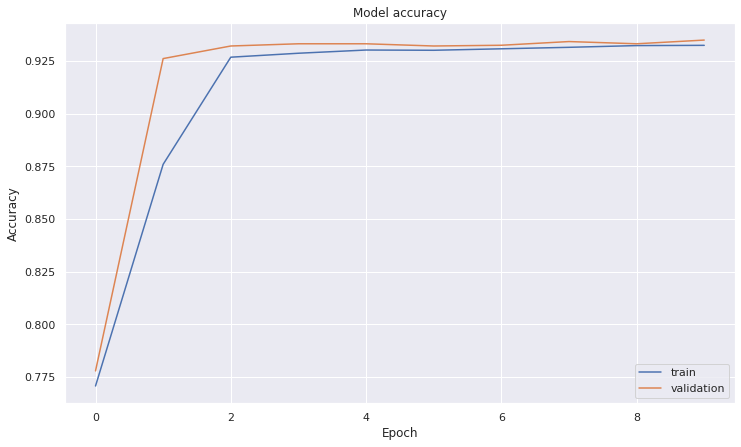

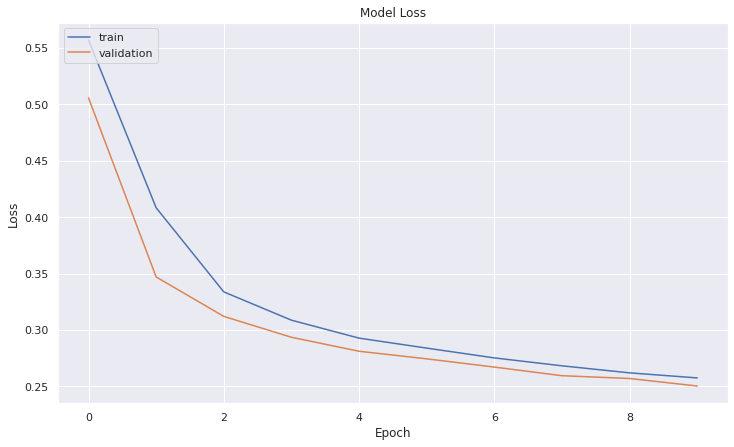

Accuracy = 0.929, F1 Score = 0.797, Precision = 0.980, recall = 0.692


In [119]:
model_lstm = Sequential()
# Embedded layer
model_lstm.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False))
# Convolutional Layer

model_lstm.add(LSTM(1, input_shape = (data_train.shape[0], data_train.shape[1])))
model_lstm.add(Dense(1,activation='sigmoid'))
#model_lstm.compile(optimizer = 'adam', loss='mse')


lstm_metrics = get_metrics(model_lstm,data_train,labels_train,data_val, labels_val,data_test,labels_test)

In [120]:
def create_cnn_lstm():  
  model = Sequential()
  # Embedded layer
  model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], 
                              input_length=MAX_SEQUENCE_LENGTH, trainable=False))
  # Convolutional Layer
  model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.2))
  # LSTM Layer
  model.add(LSTM(300))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  return model

Epoch 1/10
214/214 [==============================] - 5s 13ms/step - loss: 0.3272 - accuracy: 0.8858 - f1_m: 0.6286 - precision_m: 0.8522 - recall_m: 0.5214 - val_loss: 0.2375 - val_accuracy: 0.9293 - val_f1_m: 0.7905 - val_precision_m: 0.9763 - val_recall_m: 0.6805
Epoch 2/10
214/214 [==============================] - 2s 11ms/step - loss: 0.2383 - accuracy: 0.9293 - f1_m: 0.8009 - precision_m: 0.9794 - recall_m: 0.6923 - val_loss: 0.2245 - val_accuracy: 0.9353 - val_f1_m: 0.8101 - val_precision_m: 0.9772 - val_recall_m: 0.7065
Epoch 3/10
214/214 [==============================] - 2s 11ms/step - loss: 0.2228 - accuracy: 0.9327 - f1_m: 0.8156 - precision_m: 0.9880 - recall_m: 0.7088 - val_loss: 0.2307 - val_accuracy: 0.9339 - val_f1_m: 0.8048 - val_precision_m: 0.9786 - val_recall_m: 0.6994
Epoch 4/10
214/214 [==============================] - 2s 11ms/step - loss: 0.2069 - accuracy: 0.9339 - f1_m: 0.8115 - precision_m: 0.9836 - recall_m: 0.7118 - val_loss: 0.2373 - val_accuracy: 0.9343 

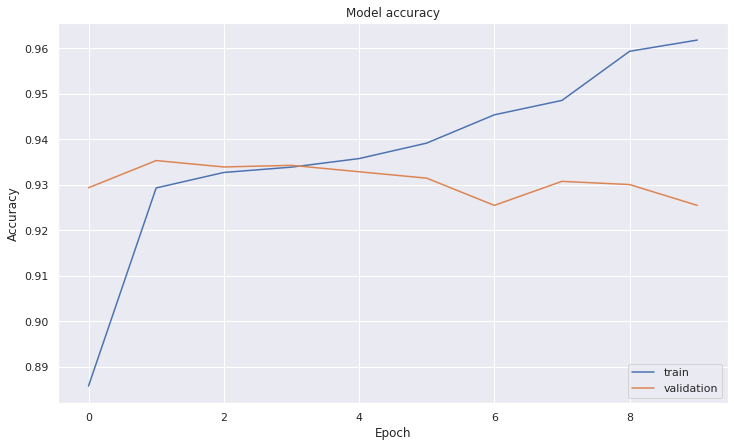

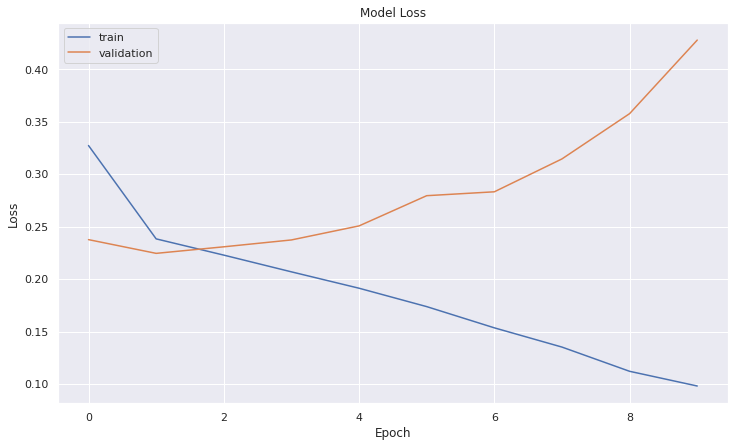

Accuracy = 0.922, F1 Score = 0.783, Precision = 0.917, recall = 0.703


In [121]:
model_cnn_lstm = create_cnn_lstm()
metrics = get_metrics(model_cnn_lstm,data_train,labels_train,data_val, labels_val,data_test,labels_test)

In [ ]:
metrics

In [ ]:
#early_stop = EarlyStopping(monitor='val_loss', patience=3)

# hist_ccn_lstm = model.fit(data_train, labels_train, \
#         validation_data=(data_val, labels_val), \
#         epochs=5, batch_size=40, shuffle=True)

Epoch 1/10
214/214 [==============================] - 2s 5ms/step - loss: 5.2644 - accuracy: 0.7025 - f1_m: 0.2081 - precision_m: 0.2667 - recall_m: 0.2135 - val_loss: 0.6216 - val_accuracy: 0.7888 - val_f1_m: 0.2243 - val_precision_m: 0.5417 - val_recall_m: 0.1525
Epoch 2/10
214/214 [==============================] - 1s 6ms/step - loss: 0.7591 - accuracy: 0.7567 - f1_m: 0.2397 - precision_m: 0.4149 - recall_m: 0.1955 - val_loss: 0.6042 - val_accuracy: 0.8018 - val_f1_m: 0.2335 - val_precision_m: 0.6667 - val_recall_m: 0.1497
Epoch 3/10
214/214 [==============================] - 2s 7ms/step - loss: 0.6095 - accuracy: 0.7816 - f1_m: 0.2549 - precision_m: 0.5259 - recall_m: 0.1833 - val_loss: 0.5369 - val_accuracy: 0.8004 - val_f1_m: 0.2369 - val_precision_m: 0.6451 - val_recall_m: 0.1550
Epoch 4/10
214/214 [==============================] - 1s 5ms/step - loss: 0.5413 - accuracy: 0.7904 - f1_m: 0.2411 - precision_m: 0.5371 - recall_m: 0.1670 - val_loss: 0.5043 - val_accuracy: 0.8035 - va

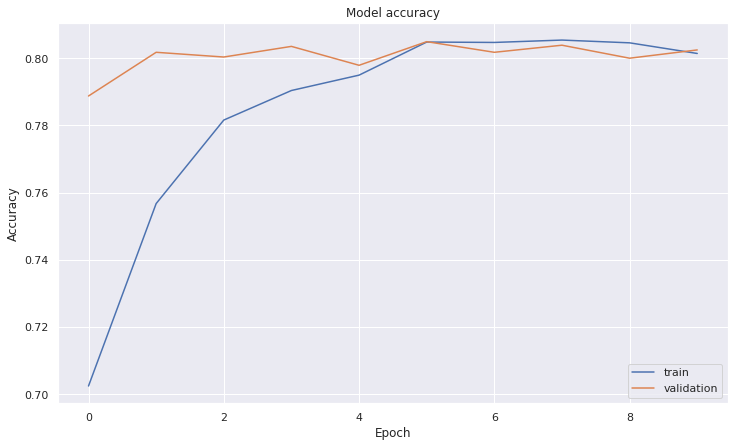

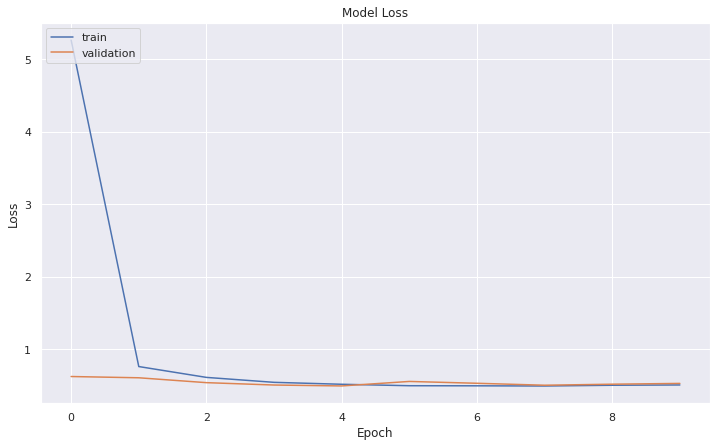

Accuracy = 0.807, F1 Score = 0.243, Precision = 0.642, recall = 0.158


In [128]:
def create_model(): 
  model = keras.models.Sequential()
  model.add(Dense(500,activation='relu', input_dim=140))
#  model.add(Dense(500,activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(500,activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(500,activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(500,activation='relu'))
  model.add(Dense(500,activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(500,activation='relu'))
  model.add(Dropout(0.2))
#  model.add(Dense(1024,activation='relu'))
  model.add(Dense(1024,activation='relu'))

  # model.add(Dense(500,activation='relu', input_dim=140))
  # model.add(Dropout(0.2))
  # model.add(Dense(500,activation='relu'))
  # model.add(Dropout(0.2))
  # model.add(Dense(500,activation='relu'))
  # model.add(Dense(500,activation='relu'))
  # model.add(Dropout(0.2))
  # model.add(Dense(500,activation='relu'))
  # model.add(Dropout(0.2))
  # model.add(Dense(1024,activation='relu'))

  model.add(Dense(1,activation='sigmoid'))
  
  model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
  return model

#for train_index,test_index in ms.KFold(n_splits=5).split(df,y):
model_dnn = create_model()
metrics_dnn = get_metrics(model_dnn,data_train,labels_train,data_val, labels_val,data_test,labels_test)

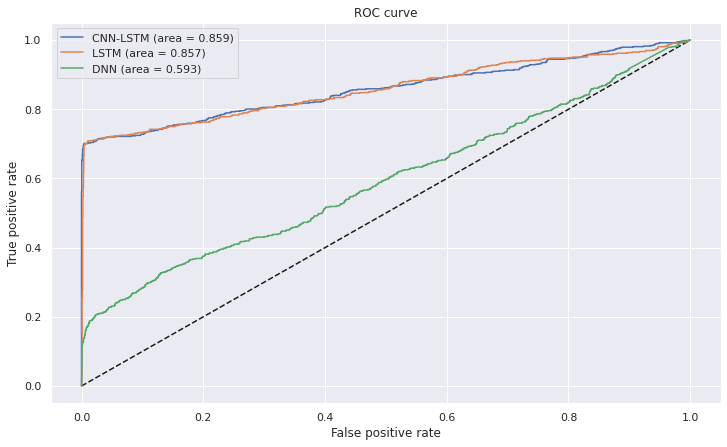

In [129]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_pred_keras = model_cnn_lstm.predict(data_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels_test, y_pred_keras)
auc_keras_cnn_lstm = auc(fpr_keras, tpr_keras)

y_pred_keras = model_lstm.predict(data_test).ravel()
fpr_keras_lstm, tpr_keras_lstm, thresholds_keras = roc_curve(labels_test, y_pred_keras)
auc_keras_lstm = auc(fpr_keras_lstm, tpr_keras_lstm)

y_pred_keras = model_dnn.predict(data_test).ravel()
fpr_keras_dnn, tpr_keras_dnn, thresholds_keras = roc_curve(labels_test, y_pred_keras)
auc_keras_dnn = auc(fpr_keras_dnn, tpr_keras_dnn)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='CNN-LSTM (area = {:.3f})'.format(auc_keras_cnn_lstm))
plt.plot(fpr_keras_lstm, tpr_keras_lstm, label='LSTM (area = {:.3f})'.format(auc_keras_lstm))
plt.plot(fpr_keras_dnn, tpr_keras_dnn, label='DNN (area = {:.3f})'.format(auc_keras_dnn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
fig = plt.gcf()
fig.set_size_inches(12,7)
fig.savefig('roc_auc.png')
plt.show()

In [ ]:
y_pred_keras = model_cnn_lstm.predict(data_test).ravel()
y_pred_keras

In [ ]:
#https://github.com/peijoy/DetectDepressionInTwitterPosts/blob/master/DepressionDetectionInTwitter.ipynb
#https://www.mdpi.com/1999-4893/13/1/7/htm